In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from scipy.linalg import sqrtm
from scipy.linalg import inv
from sklearn.neighbors import KernelDensity

def bayes(file_name):
    
    name = file_name[:-4].upper()
    data = pd.read_csv(file_name, header=None)
    data = data.dropna()
    data.columns = ['Exit Velocity','Launch Angle']

    cov_matrix = data.cov()
    velo_mean = data['Exit Velocity'].mean()
    angle_mean = data['Launch Angle'].mean()
    data['Z - Exit Velocity'] = (data['Exit Velocity'] - velo_mean) / np.sqrt(np.array(cov_matrix)[0,0])
    data['Z - Launch Angle'] = (data['Launch Angle'] - angle_mean) / np.sqrt(np.array(cov_matrix)[1,1])
    z_cov_mat = data[['Z - Exit Velocity', 'Z - Launch Angle']].cov()

    x_coords, y_coords = np.mgrid[data['Z - Exit Velocity'].min() - 2:data['Z - Exit Velocity'].max() + 2:.1, 
                    data['Z - Launch Angle'].min() - 2:data['Z - Launch Angle'].max() + 2:.1]

    X, Y = np.mgrid[data['Exit Velocity'].min() - 10:data['Exit Velocity'].max() + 10:x_coords.shape[0] + 0j, 
                    data['Launch Angle'].min() - 10:data['Launch Angle'].max() + 10:x_coords.shape[1] + 0j]
    
    pos = np.dstack((x_coords,y_coords))
    mult_dist = multivariate_normal(mean = [0,0], cov = z_cov_mat)
    
    alpha = [0,0]
    heights = np.empty((pos.shape[0], pos.shape[1]))
    for i in range(pos.shape[0]):
        for j in range(pos.shape[1]):
            heights[i,j] = norm.cdf(np.dot(alpha,pos[i,j,:].T))
    Z = 2*mult_dist.pdf(pos)*heights

    plt.contourf(x_coords,y_coords,Z,levels=100,cmap='rocket')
    plt.scatter(x=data['Z - Exit Velocity'], y=data['Z - Launch Angle'], alpha=0.2, c='white')
    plt.show()
    return

def make_heat_map(file_name):

    name = file_name[:-4].upper()
    data = pd.read_csv(file_name, header=None)
    data = data.dropna()

    kde = KernelDensity(bandwidth = 1.0, kernel = 'gaussian').fit(data)
    samples = kde.sample(n_samples = 10000, random_state = 42)

    data = pd.DataFrame(data, columns=['Exit Velocity','Launch Angle'])
    samples = pd.DataFrame(samples, columns=['Exit Velocity','Launch Angle'])
    sns.set_theme(style="white")

    clip_min_x = min(samples['Exit Velocity']) - 10
    clip_max_x = max(samples['Exit Velocity']) + 10
    clip_min_y = min(samples['Launch Angle']) - 10
    clip_max_y = max(samples['Launch Angle']) + 10

    g = sns.JointGrid(data=samples, x='Exit Velocity', y='Launch Angle', space=0)
    g.plot_joint(sns.kdeplot,
             fill=True, cut = 20, clip = ((clip_min_x,clip_max_x),(clip_min_y,clip_max_y)),
             thresh=0, levels=100, cmap="rocket")
    g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)
    if (name[-1] == 'S'):
        g.fig.suptitle(name + "' HEAT MAP\n", y = 1.02)
    else: 
        g.fig.suptitle(name + "'S HEAT MAP\n", y = 1.02)
    


def similarity_score(file1, file2):
    data1 = pd.read_csv(file1, header=None)
    data1 = data1.dropna()
    kde1 = KernelDensity(bandwidth = 1.0, kernel = 'gaussian').fit(data1)

    data2 = pd.read_csv(file2, header=None)
    data2 = data2.dropna()
    kde2 = KernelDensity(bandwidth = 1.0, kernel = 'gaussian').fit(data2)

    min_exit_velocity = int(min(min(data1[0]),min(data2[0])) - 10)
    max_exit_velocity = int(max(max(data1[0]),max(data2[0])) + 10)
    min_launch_angle = int(min(min(data1[1]),min(data2[1])) - 10)
    max_launch_angle = int(max(max(data1[1]),max(data2[1])) + 10)

    score_sum = 0
    x_range = range(min_exit_velocity,max_exit_velocity)
    y_range = range(min_launch_angle,max_launch_angle)
    lattice_size = len(x_range) * len(y_range)
    for x in x_range:
        for y in y_range:
            score_sum += abs(kde1.score(np.array([x,y]).reshape(1,-1)) - kde2.score(np.array([x,y]).reshape(1,-1)))

    return np.ceil((score_sum / lattice_size) * 100) / 100 / 100
        


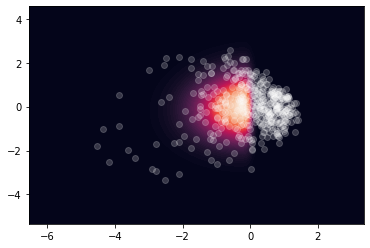

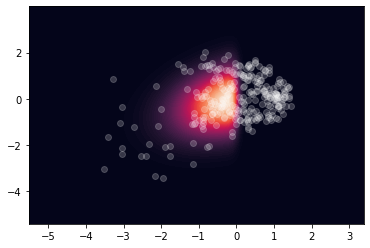

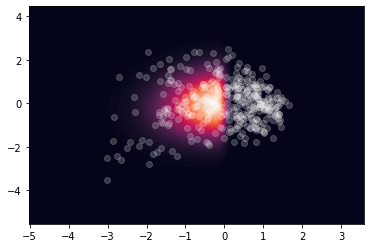

In [39]:
#~9 seconds per heat map
bayes('mullins.csv')
bayes('gallo.csv')
bayes('judge.csv')

In [40]:
#~8.5 seconds per comparison
print('Mullins v Gallo: ' + str(similarity_score('mullins.csv','gallo.csv')))
print('Mullins v Judge: ' + str(similarity_score('mullins.csv','judge.csv')))
print('Gallo v Judge: ' + str(similarity_score('gallo.csv','judge.csv')))
print('Judge v Gallo: ' + str(similarity_score('judge.csv','gallo.csv')))
print('Mullins v Mullins: ' + str(similarity_score('mullins.csv','mullins.csv')))

Mullins v Gallo: 1.0314


KeyboardInterrupt: 